In [68]:
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker as ticker
import time
from typing import List, Tuple, Callable

In [69]:
# Import dependencies
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.utils import shuffle
import joblib
from sklearn.model_selection import cross_validate

from sklearn.neural_network import MLPRegressor

In [90]:
def ANN_Train(X, y, test_size, train_size, k, epochs, hidden_nodes, hidden_layers, batch_size, learning_rate):

    print("Training ANN model...")

    # Create tuple for hidden layers
    hidden_layer_sizes = tuple(np.full(hidden_layers, hidden_nodes))

    # Split into testing and training data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, random_state=42)

    # Create model
    model = Pipeline([('scaler', StandardScaler(with_mean=True)), ('ANN', MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=batch_size, max_iter=epochs, learning_rate_init=learning_rate))])

    print("Cross validating...")

    # K-fold cross validation
    scores = cross_validate(model, X_train, y_train, cv=k, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

    # Calculate MSE, RMSE, R2 values
    Best_CV_MSE = min(abs(scores['test_neg_mean_squared_error']))
    Best_CV_RMSE = np.sqrt(Best_CV_MSE)
    Best_CV_R2 = max(scores['test_r2'])
    Worst_CV_MSE = max(abs(scores['test_neg_mean_squared_error']))
    Worst_CV_RMSE = np.sqrt(Worst_CV_MSE)
    Worst_CV_R2 = min(scores['test_r2'])
    Ave_CV_MSE = np.average(abs(scores['test_neg_mean_squared_error']))
    Ave_CV_RMSE = np.sqrt(Ave_CV_MSE)
    Ave_CV_R2 = np.average(scores['test_r2'])

    # Print out cross validation history data
    print("~~~~ Cross Validation Results ~~~~")
    print("Best MSE CV: ", Best_CV_MSE)
    print("Best RMSE CV: ", Best_CV_RMSE)
    print("Best R2 CV: ", Best_CV_R2)
    print("Worst MSE CV: ", Worst_CV_MSE)
    print("Worst RMSE CV: ", Worst_CV_RMSE)
    print("Worst R2 CV: ", Worst_CV_R2)
    print('Average MSE CV: ', Ave_CV_MSE)
    print('Average RMSE CV: ', Ave_CV_RMSE)
    print("Average R2 CV: ", Ave_CV_R2)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    print("Fitting model...")

    # Fit model
    model.fit(X_train, y_train)

    # Output cross validation data
    CrossValData = [Best_CV_MSE, Best_CV_RMSE, Best_CV_R2, Worst_CV_MSE, Worst_CV_RMSE, Worst_CV_R2, Ave_CV_MSE, Ave_CV_RMSE, Ave_CV_R2]

    return model, X_test, y_test, CrossValData

def ANN_Test(model, X_test, y_test):

    print("Testing model...")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate R2, RMSE, and MSE metrics for test data
    Test_R2 = r2_score(y_test, y_pred)
    Test_MSE = mean_squared_error(y_test, y_pred, squared=True)
    Test_RMSE = np.sqrt(Test_MSE)

    # Print model info after CV
    print("~~~~~~~~~ Final Model Structure Info ~~~~~~~~~")
    print("Number of Layers: ", model[1].n_layers_)
    print("Number of input features: ", model[1].n_features_in_)
    print("Number of outputs: ", model[1].n_outputs_)
    print("Number of iterations ran: ", model[1].n_iter_)
    print("~~~~~~~~~ Final Model Error Info ~~~~~~~~~")
    print("Test MSE: ", Test_MSE)
    print("Test RMSE: ", Test_RMSE)
    print("Test R2: ", Test_R2)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    # Plot ANN results.
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("ANN Results")

    ax[0].plot(np.linspace(1, len(model[1].loss_curve_), len(model[1].loss_curve_)), model[1].loss_curve_)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss (Mean Squared Error)")
    ax[0].set_title('Epoch History, MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}'.format(Test_MSE, Test_RMSE, Test_R2), fontsize=7)

    # Parity Plot
    ax[1].plot(y_test, y_pred, 'r*')
    ax[1].set_xlabel("y_test")
    ax[1].set_ylabel("y_pred")
    ax[1].set_title('Parity Plot, MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}'.format(Test_MSE, Test_RMSE, Test_R2), fontsize=7)
    plt.tight_layout()

    return Test_R2, Test_RMSE, Test_MSE

In [84]:
# Dataset Import
df = pd.read_csv('merged_beadnumber.csv', usecols=lambda x: 'Unnamed' not in x)

## Artificial Neural Network Parameters
### Constants 
 - test_size, train_size = 0.2, 0.8 - standard train/test split
 - k: cross-validation folds 
 - activation: Activation function for the hidden layer
 - solver: solver for weight optimization (adam)
  - epochs: Maximum number of iterations for solving
 - learning_rate : Initial learning weight for step-size in updating weights.
 ### Hyperparameters
 - Hidden_layers_sizes: Tuples of layers and those layer sizes The ith element represents the number of neurons in the ith hidden layer.
 - hidden_nodes: Number of neurons per hidden layer
 - batch_size: Size of minibatches

In [85]:
# Define ANN model hidden layer structure and training parameters

'''
# Develop hidden layer tuples 
hidden_layers = [1, 3, 5]
hidden_nodes = [3, 5, 7]
hidden_layer_sizes  = [tuple(np.full(lay, nodes)) for lay in hidden_layers for nodes in hidden_nodes]
hidden_layer_sizes += [(3,5,3), (3,5,7,5,3), (5,7,5)]

# Initialize parmesan cheese
params = {'hidden_layer_sizes': hidden_layer_sizes,
         'learning_rate_init': 0.01,
         'epochs': 500,
         'batch_size': 100,
         }

valtype = 'MovAvg'
val = "Current" # ['Current', 'Voltage', 'CTWD']
# 
featlist = ['std', 'skew', 'kurt', 'mean']
features = [f'{feat}_{valtype}{val}' for feat in featlist]
print(features)
    # Parse dataset
    '''
def ANN_GridSearch(X_train, X_test, y_train, y_test, params):
    model = Pipeline([('scaler', StandardScaler(with_mean=True)), 
                  ('ANN', MLPRegressor(activation='relu', solver='adam'))])
    clf = GridSearchCV(model, params)
    clf.fit(X, y)
    score = clf.score(X_test, y_test)
    #results = clf.cv_results_
    #for mean_score, params in zip(results["mean_test_score"], results["params"]):
    #    print(params, "=>", mean_score)
        

In [87]:
if DataEfficiencyToggle == 0:
    StatisticalFeatures = ['StDev', 'Skew', 'Kurtosis']

    # Iterate through power levels and dwell time to parse out full process data pertaining to build with power P and dwell D

        # Iterate through all 20 layers of each full process dataset, calculate stat features, and save as new dataset or add to old one

        # Iterate through data stream types (ie current, CTWD, etc.) used for predicted value (ie y)

            # Define input and output variables (X and y) for both sparse and remainder data sets
            X
            y

            # Train ANN using data set
            model, X_test, y_test, CrossValData = ANN_Train(X, y, test_size, train_size, k, epochs, hidden_nodes, hidden_layers, batch_size, learning_rate)

            # Test ANN using to determine performance of model
            Test_R2, Test_RMSE, Test_MSE = ANN_Test(model, X_test, y_test)

if DataEfficiencyToggle == 1:

    # Iterate through power levels and dwell time to parse out full process data pertaining to build with power P and dwell D (save P and D for NN inputs)

        # Iterate through number of packets in DOE
        PacketTime = # length of each packet in seconds (each bead is approximately 22 seconds long, so maybe try 2, 5, 10, and 22 second long packets?)

            # Iterate through list of layers used in sparse data analysis
            LayerNumbers = # list of lists of integer values between 1 and 20, eg [1, 10, 20], [1, 5, 10, 15, 20], etc.

                # Divide full process data into two data structures, one with sparse data layers, and one with remainder data layers

                    # Iterate through data stream types (ie current, CTWD, etc.) used for predicted value (ie y)

                        # Define input and output variables (X and y) for both sparse and remainder data sets
                        SparseX
                        SparseY

                        RemainderX
                        RemainderY

                        # Train ANN using sparse data set
                        model, SparseX_test, SparseY_test, CrossValData = ANN_Train(SparseX, SparseY, test_size, train_size, k, epochs, hidden_nodes, hidden_layers, batch_size, learning_rate)

                        # Test ANN using to determine performance of model using sparse data set
                        SparseDataTest_R2, SparseDataTest_RMSE, SparseDataTest_MSE = ANN_Test(model, SparseX_test, SparseY_test)

                        # Test ANN using remainder of data to determine how well model can predict data in the interim
                        RemainderDataTest_R2, RemainderDataTest_RMSE, RemainderDataTest_MSE = ANN_Test(model, RemainderX, RemainderY)

# Show plots
plt.show()

NameError: name 'SparseX' is not defined

Training ANN model...
Cross validating...


/Users/nikkivanhandel/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


~~~~ Cross Validation Results ~~~~
Best MSE CV:  3.619153213187054
Best RMSE CV:  1.9024072153950253
Best R2 CV:  0.29779160191225396
Worst MSE CV:  5866.262647072246
Worst RMSE CV:  76.59153117069958
Worst R2 CV:  -129.35257240736271
Average MSE CV:  1178.3183587907251
Average RMSE CV:  34.32664211353515
Average R2 CV:  -25.691189074510213
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting model...
Testing model...
~~~~~~~~~ Final Model Structure Info ~~~~~~~~~
Number of Layers:  7
Number of input features:  3
Number of outputs:  4
Number of iterations ran:  425
~~~~~~~~~ Final Model Error Info ~~~~~~~~~
Test MSE:  5.25637690402728
Test RMSE:  2.292678979715058
Test R2:  0.20162530568515788
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


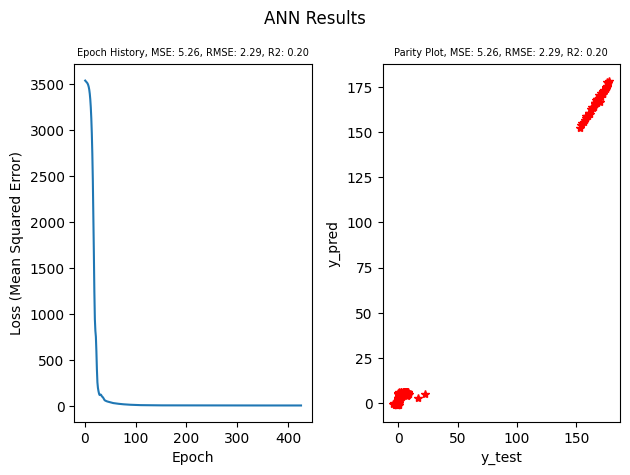

In [108]:
test_size, train_size = 0.2, 0.8
k = 5

# e.g.
hidden_layers = 5
hidden_nodes = 10
test_size = 0.2
train_size = 0.8
k = 5
batch_size = 100
epochs = 750
learning_rate = 0.01

model, X_test, y_test, CrossValData = ANN_Train(X, y, test_size, train_size, k, epochs, hidden_nodes, hidden_layers, batch_size, learning_rate)

# Test ANN using to determine performance of model
Test_R2, Test_RMSE, Test_MSE = ANN_Test(model, X_test, y_test)


# 